# HW 2 - Naive Bayes in Hadoop MR
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

In the live sessions for week 2 and week 3 you got some practice designing and debugging Hadoop Streaming jobs. In this homework we'll use Hadoop MapReduce to implement your first parallelized machine learning algorithm: Naive Bayes. As you develop your implementation you'll test it on a small dataset that matches the 'Chinese Example' in the _Manning, Raghavan and Shutze_ reading for Week 2. For the main task in this assignment you'll be working with a small subset of the Enron Spam/Ham Corpus. By the end of this assignment you should be able to:
* __... describe__ the Naive Bayes algorithm including both training and inference.
* __... perform__ EDA on a corpus using Hadoop MR.
* __... implement__ parallelized Naive Bayes.
* __... constrast__ partial, unordered and total order sort and their implementations in Hadoop Streaming.
* __... explain__ how smoothing affects the bias and variance of a Multinomial Naive Bayes model.

As always, your work will be graded both on the correctness of your output and on the clarity and design of your code. __Please refer to the `README` for homework submission instructions.__ 

## Notebook Setup
Before starting, run the following cells to confirm your setup.

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# global vars (paths) - ADJUST AS NEEDED
JAR_FILE = "/usr/lib/hadoop-mapreduce/hadoop-streaming.jar"
HDFS_DIR = "/user/root/HW2/"
HOME_DIR = "/Desktop/su20-4-shweta-sen/Assignments/HW2" # FILL IN HERE eg. /media/notebooks/Assignments/HW2

In [3]:
# save path for use in Hadoop jobs (-cmdenv PATH={PATH})
from os import environ
PATH  = environ['PATH']

In [4]:
# data path
# changed path to add master folder nesting
ENRON = "master/data/enronemail_1h.txt"

In [5]:
# make the HDFS directory if it doesn't already exist
!hdfs dfs -ls 
!hdfs dfs -mkdir {HDFS_DIR}

Found 1 items
drwxr-xr-x   - root supergroup          0 2020-05-28 06:44 HW2
mkdir: `/user/root/HW2': File exists


# Question 1: Hadoop MapReduce Key Takeaways.  

This assignment will be the only one in which you use Hadoop Streaming to implement a distributed algorithm. The key reason we continue to teach Hadoop streaming is because of the way it forces the programmer to think carefully about what is happening under the hood when you parallelize a calculation. This question will briefly highlight some of the most important concepts that you need to understand about Hadoop Streaming and MapReduce before we move on to Spark next week.   

### Q1 Tasks:

* __a) short response:__ What "programming paradigm" is Hadoop MapReduce based on? What are the main ideas of this programming paradigm and how does MapReduce exemplify these ideas?

* __b) short response:__ What is the Hadoop Shuffle? When does it happen? Why is it potentially costly? Describe one specific thing we can we do to mitigate the cost associated with this stage of our Hadoop Streaming jobs.

* __c) short response:__ In Hadoop Streaming why do the input and output record format of a combiner script have to be the same? [__`HINT`__ _what level of combining does the framework guarantee? what is the relationship between the record format your mapper emits and the format your reducer expects to receive?_]

* __d) short response:__ To what extent can you control the level of parallelization of your Hadoop Streaming jobs? Please be specific.

* __e) short response:__ What change in the kind of computing resources available prompted the creation of parallel computation frameworks like Hadoop? 

### Q1 Student Answers:

> __a)__ Hadoop MapReduce is based on the functional programming paradigm. It exemplifies the paradigm first by performing all processing through "map" and "reduce" tasks, whereby inputs are transformed into key/value pairs which then get aggregated. MapReduce also exemplifies the paradigm because it allows the output of one function to become the input to the next. As a result, the results are consistent provided the input is identical.

> __b)__ Hadoop Shuffle is the process of partioning, shuffling, and sorting data. It occcurs between the mapping and reducing phases. It is potentially costly from a time and computation perspective, particularlly during data sorting. The cost can be mitigated through the use of combiners and optimization. 

> __c)__ Combiners are optional, so the input and output record format of a combiner script need to be the same because there is no guarantee that the MapReduce job will utilize the combiner. The output format from the mapper and the input format for the reducer must be consistent irrespective of whether a combiner is used.  

> __d)__ The parallelization of a Hadoop Streaming job can be controlled by adjusting the data block size or the conf.setNumMapTasks(int num) setting to control the number of available mappers. The number of reducers can also be controlled using the conf.setNumReduceTasks(int num) setting.

> __e)__ The widespread availability of large scale data sets prompted the creation of parallel computation frameworks like Hadoop. The frameworks were enabled by advances in disk and RAM storage technology that allowed processing of higher quantities of data.


# Question 2: MapReduce Design Patterns.  

In the last two live sessions and in your readings from Lin & Dyer you encountered a number of techniques for manipulating the logistics of a MapReduce implementation to ensure that the right information is available at the right time and location. In this question we'll review a few of the key techniques you learned.   

### Q2 Tasks:

* __a) short response:__ What are counters (in the context of Hadoop Streaming)? How are they useful? What kinds of counters does Hadoop provide for you? How do you create your own custom counter?

* __b) short response:__ What are composite keys? How are they useful? How are they related to the idea of custom partitioning?

* __c) short response:__ What is the order inversion pattern? What problem does it help solve? How do we implement it? 

# Question 3: Understanding Total Order Sort

The key challenge in distributed computing is to break a problem into a set of sub-problems that can be performed without communicating with each other. Ideally, we should be able to define an arbirtary number of splits and still get the right result, but that is not always possible. Parallelization becomes particularly challenging when we need to make comparisons between records, for example when sorting. Total Order Sort allows us to order large datasets in a way that enables efficient retrieval of results. Before beginning this assignment, make sure you have read and understand the [Total Order Sort Notebook](https://github.com/UCB-w261/main/tree/master/HelpfulResources/TotalSortGuide/_total-sort-guide-spark2.01-JAN27-2017.ipynb). You can skip the first two MRJob sections, but the rest of section III and all of section IV are **very** important (and apply to Hadoop Streaming) so make sure to read them closely. Feel free to read the Spark sections as well but you won't be responsible for that material until later in the course. To verify your understanding, answer the following questions.

### Q3 Tasks:

* __a) short response:__ What is the difference between a partial sort, an unordered total sort, and a total order sort? From the programmer's perspective, what does total order sort allow us to do that we can't with unordered total? Why is this important with large datasets?

* __b) short response:__ Which phase of a MapReduce job is leveraged to implement Total Order Sort? Which default behaviors must be changed. Why must they be changed?

* __c) short response:__ Describe in words how to configure a Hadoop Streaming job for the custom sorting and partitioning that is required for Total Order Sort.  

* __d) short response:__ Explain why we need to use an inverse hash code function.

* __e) short response:__ Where does this function need to be located so that a Total Order Sort can be performed?

### Q3 Student Answers:

> __a)__ A partial sort occurs when keys are sorted into each individual partition file (which is the default behavior for most MapReduce frameworks). An unordered total sort occurs when keys are sorted across all parition files (which not stacked in order). A total sort occurs when keys are sorted across all parition files in the correct order. From a programmer's perspective, total order sort is beneficial for algorithms requiring sorted inputs and helpful for improving computational efficiency, especially for large data sets where the chunked data would need to be sent to multiple reducers while maintaining sort order across partitions. 

> __b)__ The shuffle phase of MapReduce is leveraged to implement total order sort. The default partioner and sort methods must be changed because it would otherwise default to providing partial sort results. 

> __c)__ Hadoop Streaming jobs need Hadoop Streaming parameters to be specified (e.g. KeyFieldBasedPartitioner, KeyFieldBasedComparator) and configured for custom sorting and partioning required for total order sort. 

> __d)__ The inverse hash function is needed to preserve partition key ordering and is used to find the correct partition index. 

> __e)__ For total order sort to be performed, the function needs to be located in the KeyBasedPartitioner argument of Hadoop Streaming.

# About the Data
For the main task in this portion of the homework you will train a classifier to determine whether an email represents spam or not. You will train your Naive Bayes model on a 100 record subset of the Enron Spam/Ham corpus available in the HW2 data directory (__`HW2/data/enronemail_1h.txt`__).

__Source:__   
The original data included about 93,000 emails which were made public after the company's collapse. There have been a number raw and preprocessed versions of this corpus (including those available [here](http://www.aueb.gr/users/ion/data/enron-spam/index.html) and [here](http://www.aueb.gr/users/ion/publications.html)). The subset we will use is limited to emails from 6 Enron employees and a number of spam sources. It is part of [this data set](http://www.aueb.gr/users/ion/data/enron-spam/) which was created by researchers working on personlized Bayesian spam filters. Their original publication is [available here](http://www.aueb.gr/users/ion/docs/ceas2006_paper.pdf). __`IMPORTANT!`__ _For this homework please limit your analysis to the 100 email subset which we provide. No need to download or run your analysis on any of the original datasets, those links are merely provided as context._

__Preprocessing:__  
For their work, Metsis et al. (the authors) appeared to have pre-processed the data, not only collapsing all text to lower-case, but additionally separating "words" by spaces, where "words" unfortunately include punctuation. As a concrete example, the sentence:  
>  `Hey Jon, I hope you don't get lost out there this weekend!`  

... would have been reduced by Metsis et al. to the form:  
> `hey jon , i hope you don ' t get lost out there this weekend !` 

... so we have reverted the data back toward its original state, removing spaces so that our sample sentence would now look like:
> `hey jon, i hope you don't get lost out there this weekend!`  

Thus we have at least preserved contractions and other higher-order lexical forms. However, one must be aware that this reversion is not complete, and that some object (specifically web sites) will be ill-formatted, and that all text is still lower-cased.


__Format:__   
All messages are collated to a tab-delimited format:  

>    `ID \t SPAM \t SUBJECT \t CONTENT \n`  

where:  
>    `ID = string; unique message identifier`  
    `SPAM = binary; with 1 indicating a spam message`  
    `SUBJECT = string; title of the message`  
    `CONTENT = string; content of the message`   
    
Note that either of `SUBJECT` or `CONTENT` may be "NA", and that all tab (\t) and newline (\n) characters have been removed from both of the `SUBJECT` and `CONTENT` columns.  

In [6]:
!pwd

/media/notebooks/Assignments/HW2


In [7]:
# take a look at the first 100 characters of the first 5 records (RUN THIS CELL AS IS)
!head -n 5 /media/notebooks/Assignments/HW2/{ENRON} | cut -c-100

0001.1999-12-10.farmer	0	 christmas tree farm pictures	NA
0001.1999-12-10.kaminski	0	 re: rankings	 thank you.
0001.2000-01-17.beck	0	 leadership development pilot	" sally:  what timing, ask and you shall receiv
0001.2000-06-06.lokay	0	" key dates and impact of upcoming sap implementation over the next few week
0001.2001-02-07.kitchen	0	 key hr issues going forward	 a) year end reviews-report needs generating 


In [8]:
# see how many messages/lines are in the file 
#(this number may be off by 1 if the last line doesn't end with a newline)
!wc -l /media/notebooks/Assignments/HW2/{ENRON}

100 /media/notebooks/Assignments/HW2/master/data/enronemail_1h.txt


In [9]:
# make the HDFS directory if it doesn't already exist
!hdfs dfs -mkdir {HDFS_DIR}

mkdir: `/user/root/HW2': File exists


In [10]:
# load the data into HDFS (RUN THIS CELL AS IS)
!hdfs dfs -copyFromLocal /media/notebooks/Assignments/HW2/{ENRON} {HDFS_DIR}/enron.txt

copyFromLocal: `/user/root/HW2/enron.txt': File exists


In [11]:
!hdfs dfs -ls {HDFS_DIR}

Found 13 items
drwxr-xr-x   - root supergroup          0 2020-05-28 06:20 /user/root/HW2/chinese-output
-rw-r--r--   1 root supergroup        119 2020-05-28 06:19 /user/root/HW2/chineseTest.txt
-rw-r--r--   1 root supergroup        107 2020-05-28 06:19 /user/root/HW2/chineseTrain.txt
drwxr-xr-x   - root supergroup          0 2020-05-28 06:19 /user/root/HW2/eda-output
drwxr-xr-x   - root supergroup          0 2020-05-28 06:19 /user/root/HW2/eda-sort-output
drwxr-xr-x   - root supergroup          0 2020-05-28 06:36 /user/root/HW2/enron-model
-rw-r--r--   1 root supergroup     204559 2020-05-28 06:09 /user/root/HW2/enron.txt
-rw-r--r--   1 root supergroup      41493 2020-05-28 06:21 /user/root/HW2/enron_test.txt
-rw-r--r--   1 root supergroup     163066 2020-05-28 06:21 /user/root/HW2/enron_train.txt
drwxr-xr-x   - root supergroup          0 2020-05-28 06:45 /user/root/HW2/evaluate-smooth-model
drwxr-xr-x   - root supergroup          0 2020-05-28 06:43 /user/root/HW2/evaluate-unsmooth-mod

# Question 4:  Enron Ham/Spam EDA.
Before building our classifier, lets get aquainted with our data. In particular, we're interested in which words occur more in spam emails than in legitimate ("ham") emails. In this question you'll implement two Hadoop MapReduce jobs to count and sort word occurrences by document class. You'll also learn about two new Hadoop streaming parameters that will allow you to control how the records output from your mappers are partitioned for reducing on separate nodes. 

__`IMPORTANT NOTE:`__ For this question and all subsequent items, you should include both the subject and the body of the email in your analysis (i.e. concatetate them to get the 'text' of the document).

### Q4 Tasks:
* __a) code:__ Complete the missing components of the code in __`EnronEDA/mapper.py`__ and __`EnronEDA/reducer.py`__ to create a Hadoop  MapReduce job that counts how many times each word in the corpus occurs in an email for each class. Pay close attention to the data format specified in the docstrings of these scripts _-- there are a number of ways to accomplish this task, we've chosen this format to help illustrate a technique in `part e`_. Run the provided unit tests to confirm that your code works as expected, then run the provided Hadoop Streaming command to apply your analysis to the Enron data.


* __b) code + short response:__ How many times does the word "__assistance__" occur in each class? (`HINT:` Use a `grep` command to read from the results file you generated in '`a`' and then report the answer in the space provided.)


* __c) short response:__ Would it have been possible to add some sorting parameters to the Hadoop streaming command that would cause our `part a` results to be sorted by count? Explain why or why not. (`HINT:` This question demands an understanding of the sequence of the phases of MapReduce.)


* __d) code + short response:__ Write a second Hadoop MapReduce job to sort the output of `part a` first by class and then by count. Run your job and save the results to a local file. Then describe in words how you would go about printing the top 10 words in each class given this sorted output. (`HINT 1:` _remember that you can simply pass the `part a` output directory to the input field of this job; `HINT 2:` since this task is just reodering the records from `part a` we don't need to write a mapper or reducer, just use `/bin/cat` for both_)


* __e) code:__ A more efficient alternative to '`grep`-ing' for the top 10 words in each class would be to use the Hadoop framework to separate records from each class into its own partition so that we can just read the top lines in each. Rewrite your job from ` part d` to specify 2 reduce tasks and to tell Hadoop to partition based on the second field (which indicates spam/ham in our data). Your code should maintain the secondary sort -- that is each partition should list words from most to least frequent.

### Q4 Student Answers:
> __b)__ The word assistance appears 1 time in "ham" emails and 10 times in "spam" emails.

> __c)__  It would not have been possible to add a parameter to sort by count. In the EnronEDA mapper, we do not aggregate the counts (it is done in EronEDA reducer). Thus, we cannot add sort parameters becase we do not have the total count by word until it gets aggregated in the reducer. 

> __d)__ The first ten lines of each partition file could be outputted to get the top 10 words of each class. We would then need to find the boundary where the class (spam/ham) changes from 0 to 1 in order to get the top 10 words for the second class. 

In [12]:
# part a - do your work in the provided scripts then RUN THIS CELL AS IS
!chmod a+x EnronEDA/mapper.py
!chmod a+x EnronEDA/reducer.py

In [13]:
# part a - unit test EnronEDA/mapper.py (RUN THIS CELL AS IS)
!echo -e "d1	1	title	body\nd2	0	title	body" | EnronEDA/mapper.py

title	1	1
body	1	1
title	0	1
body	0	1


In [14]:
# part a - unit test EnronEDA/reducer.py (RUN THIS CELL AS IS)
!echo -e "one	1	1\none	0	1\none	0	1\ntwo	0	1" | EnronEDA/reducer.py

one	0	2
one	1	1
two	0	1
two	1	0


In [15]:
# part a - clear output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-output

Deleted /user/root/HW2/eda-output


In [16]:
# part a - Hadoop streaming job (RUN THIS CELL AS IS)
!hadoop jar {JAR_FILE} \
  -files EnronEDA/reducer.py,EnronEDA/mapper.py \
  -mapper mapper.py \
  -reducer reducer.py \
  -input {HDFS_DIR}/enron.txt \
  -output {HDFS_DIR}/eda-output \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob1095400744904303004.jar tmpDir=null
20/05/29 02:42:23 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/29 02:42:24 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/29 02:42:25 INFO mapred.FileInputFormat: Total input paths to process : 1
20/05/29 02:42:25 INFO mapreduce.JobSubmitter: number of splits:2
20/05/29 02:42:25 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1590718726048_0001
20/05/29 02:42:25 INFO impl.YarnClientImpl: Submitted application application_1590718726048_0001
20/05/29 02:42:26 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1590718726048_0001/
20/05/29 02:42:26 INFO mapreduce.Job: Running job: job_1590718726048_0001
20/05/29 02:42:33 INFO mapreduce.Job: Job job_1590718726048_0001 running in uber mode : false
20/05/29 02:42:33 INFO mapreduce.Job:  map 0% reduce 0%
20/05

In [17]:
# part a - retrieve results from HDFS & copy them into a local file (RUN THIS CELL AS IS)
!hdfs dfs -cat {HDFS_DIR}/eda-output/part-0000* > EnronEDA/results.txt

In [18]:
# part b - write your grep command here
!cat EnronEDA/results.txt | grep assistance

assistance	0	2
assistance	1	8


In [19]:
# part d - clear the output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-sort-output

Deleted /user/root/HW2/eda-sort-output


In [20]:
# part d - write your Hadoop streaming job here
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D stream.map.output.field.separator="\t" \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2n -k3,3nr" \
  -mapper /bin/cat \
  -reducer /bin/cat \
  -input {HDFS_DIR}/eda-output \
  -output {HDFS_DIR}/eda-sort-output \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH} \

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob9128815449128474328.jar tmpDir=null
20/05/29 02:43:38 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/29 02:43:38 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/29 02:43:38 INFO mapred.FileInputFormat: Total input paths to process : 2
20/05/29 02:43:38 INFO mapreduce.JobSubmitter: number of splits:2
20/05/29 02:43:38 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1590718726048_0002
20/05/29 02:43:39 INFO impl.YarnClientImpl: Submitted application application_1590718726048_0002
20/05/29 02:43:39 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1590718726048_0002/
20/05/29 02:43:39 INFO mapreduce.Job: Running job: job_1590718726048_0002
20/05/29 02:43:45 INFO mapreduce.Job: Job job_1590718726048_0002 running in uber mode : false
20/05/29 02:43:45 INFO mapreduce.Job:  map 0% reduce 0%
20/05

In [21]:
# part e - clear the output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-sort-output

Deleted /user/root/HW2/eda-sort-output


In [22]:
# part e - write your Hadoop streaming job here
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D stream.map.output.field.separator="\t" \
  -D mapreduce.partition.keypartitioner.options=-k2,2 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2n -k3,3nr" \
  -mapper /bin/cat \
  -reducer /bin/cat \
  -input {HDFS_DIR}/eda-output \
  -output {HDFS_DIR}/eda-sort-output \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH} \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob8943453603642201380.jar tmpDir=null
20/05/29 02:44:23 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/29 02:44:23 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/29 02:44:23 INFO mapred.FileInputFormat: Total input paths to process : 2
20/05/29 02:44:23 INFO mapreduce.JobSubmitter: number of splits:2
20/05/29 02:44:24 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1590718726048_0003
20/05/29 02:44:24 INFO impl.YarnClientImpl: Submitted application application_1590718726048_0003
20/05/29 02:44:24 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1590718726048_0003/
20/05/29 02:44:24 INFO mapreduce.Job: Running job: job_1590718726048_0003
20/05/29 02:44:30 INFO mapreduce.Job: Job job_1590718726048_0003 running in uber mode : false
20/05/29 02:44:30 INFO mapreduce.Job:  map 0% reduce 0%
20/05

In [23]:
# part e - view the top 10 records from each partition (RUN THIS CELL AS IS)
for idx in range(2):
    print(f"\n===== part-0000{idx}=====\n")
    !hdfs dfs -cat {HDFS_DIR}/eda-sort-output/part-0000{idx} | head


===== part-00000=====

the	0	549	
to	0	398	
ect	0	382	
and	0	278	
of	0	230	
hou	0	206	
a	0	196	
in	0	182	
for	0	170	
on	0	135	
cat: Unable to write to output stream.

===== part-00001=====

the	1	698	
to	1	566	
and	1	392	
your	1	357	
a	1	347	
you	1	345	
of	1	336	
in	1	236	
for	1	204	
com	1	153	
cat: Unable to write to output stream.


__Expected output:__
<table>
<th>part-00000:</th>
<th>part-00001:</th>
<tr><td><pre>
the	0	549	
to	0	398	
ect	0	382	
and	0	278	
of	0	230	
hou	0	206	
a	0	196	
in	0	182	
for	0	170	
on	0	135
</pre></td>
<td><pre>
the	1	698	
to	1	566	
and	1	392	
your	1	357	
a	1	347	
you	1	345	
of	1	336	
in	1	236	
for	1	204	
com	1	153
</pre></td></tr>
</table>

# Question 5: Counters and Combiners.
Tuning the number of mappers & reducers is helpful to optimize very large distributed computations. Doing so successfully requires a thorough understanding of the data size at each stage of the job. As you learned in the week3 live session, counters are an invaluable resource for understanding this kind of detail. In this question, we will take the EDA performed in Question 4 as an opportunity to illustrate some related concepts.

### Q5 Tasks:
* __a) short response:__ Read the Hadoop output from your job in Question 4a to report how many records are emitted by the mappers and how many records are received be the reducers. In the context of word counting what does this number represent practically?

* __b) code:__ Note that we wrote the reducer in question 4a such that the input and output record format is identical. This makes it easy to use the same reducer script as a combiner. In the space provided below, write the Hadoop Streaming command to re-run your job from question 4a with this combining added.

* __c) short response__: Report the number of records emitted by your mappers in part b and the number of records received by your reducers. Compare your results here to what you saw in part a. Explain.

* __d) short response__: Describe a scenario where using a combiner would _NOT_ improve the efficiency of the shuffle stage. Explain. [__`BONUS:`__ how does increasing the number of mappers affect the usefulness of a combiner?]

### Q5 Student Answers:
> __a)__ The number of map output records is 31490. The number of reduce input records is 31490. In the context of word counting, the numbers represent the total number of words in the corpus. It is not representative of vocabulary size due to repeat words. 

> __c)__ The number of map output records is the same (31490) but the number of reduce input records is substantially less (13096). The combiner helped optimize the shuffling phase of MapReduce so that keys were combined from each mapper before being sent to the reducers, thus reducing the number of records emitted by the mapper by approximately 40%.

> __d)__ One scenario where a combiner would not improve the shuffle stage is when the number of mappers starts to come closer in value to its number of keys. Since the purpose of the combiner is to combine the values for similar keys in an individual mapper, this efficiency deminishes as more mappers are added. The worst case scenario in terms of combiner optimization would be an equal number of mappers to keys. As the number of mappers increases, the usefulness of a combiner decreases. 

In [24]:
# part b - clear output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-output

Deleted /user/root/HW2/eda-output


In [25]:
# part b - write your Hadoop streaming job here
!hadoop jar {JAR_FILE} \
  -files EnronEDA/reducer.py,EnronEDA/mapper.py \
  -mapper mapper.py \
  -combiner reducer.py \
  -reducer reducer.py \
  -input {HDFS_DIR}/enron.txt \
  -output {HDFS_DIR}/eda-output \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob2693157846140418220.jar tmpDir=null
20/05/29 02:51:25 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/29 02:51:26 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/29 02:51:26 INFO mapred.FileInputFormat: Total input paths to process : 1
20/05/29 02:51:26 INFO mapreduce.JobSubmitter: number of splits:2
20/05/29 02:51:26 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1590718726048_0004
20/05/29 02:51:26 INFO impl.YarnClientImpl: Submitted application application_1590718726048_0004
20/05/29 02:51:26 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1590718726048_0004/
20/05/29 02:51:26 INFO mapreduce.Job: Running job: job_1590718726048_0004
20/05/29 02:51:32 INFO mapreduce.Job: Job job_1590718726048_0004 running in uber mode : false
20/05/29 02:51:32 INFO mapreduce.Job:  map 0% reduce 0%
20/05

# Question 6: Document Classification Task Overview.
The week 2 assigned reading from Chapter 13 of _Introduction to Information Retrieval_ by Manning, Raghavan and Schutze provides a thorough introduction to the document classification task and the math behind Naive Bayes. In this question we'll use the example from Table 13.1 (reproduced below) to 'train' an unsmoothed Multinomial Naive Bayes model and classify a test document by hand.

<table>
<th>DocID</th>
<th>Class</th>
<th>Subject</th>
<th>Body</th>
<tr><td>Doc1</td><td>1</td><td></td><td>Chinese Beijing Chinese</td></tr>
<tr><td>Doc2</td><td>1</td><td></td><td>Chinese Chinese Shanghai</td></tr>
<tr><td>Doc3</td><td>1</td><td></td><td>Chinese Macao</td></tr>
<tr><td>Doc4</td><td>0</td><td></td><td>Tokyo Japan Chinese</td></tr>
</table>

### Q6 Tasks:
* __a) short response:__ Equation 13.3 in Manning, Raghavan and Shutze shows how a Multinomial Naive Bayes model classifies a document. It predicts the class, $c$, for which the estimated conditional probability of the class given the document's contents,  $\hat{P}(c|d)$, is greatest. In this equation what two pieces of information are required to calculate  $\hat{P}(c|d)$? Your answer should include both mathematical notatation and verbal explanation.


* __b) short response:__ The Enron data includes two classes of documents: `spam` and `ham` (they're actually labeled `1` and `0`). In plain English, explain what  $\hat{P}(c)$ and   $\hat{P}(t_{k} | c)$ mean in the context of this data. How will we would estimate these values from a training corpus? How many passes over the data would we need to make to retrieve this information for all classes and all words?


* __c) hand calculations:__ Above we've reproduced the document classification example from the textbook (we added an empty subject field to mimic the Enron data format). Remember that the classes in this "Chinese Example" are `1` (about China) and `0` (not about China). Calculate the class priors and the conditional probabilities for an __unsmoothed__ Multinomial Naive Bayes model trained on this data. Show the calculations that lead to your result using markdown and $\LaTeX$ in the space provided or by embedding an image of your hand written work. [`NOTE:` _Your results should NOT match those in the text -- they are training a model with +1 smoothing you are training a model without smoothing_]


* __d) hand calculations:__ Use the model you trained to classify the following test document: `Chinese Chinese Chinese Tokyo Japan`. Show the calculations that lead to your result using markdown and   $\LaTeX$ in the space provided or by embedding an image of your hand written work.


* __e) short response:__ Compare the classification you get from this unsmoothed model in `d`/`e` to the results in the textbook's "Example 1" which reflects a model with Laplace plus 1 smoothing. How does smoothing affect our inference?

### Q6 Student Answers:
> __a)__ The 2 pieces of information required to calculate $\hat{P}(c|d)$ are ${P}(t_k|c)$ and ${P}(c)$. The first variable represents the conditional probability of $t_k$ occurring in a class c document, and the second variable represents the prior probability of a document occurring in class c.

> __b)__ In the Enron example, ${P}(t_k|c)$ is exemplified by the % probability of a term like 'dear' occuring in a spam (i.e. 1) class document. ${P}(c)$ is exemplified by the prior % probability of a new document being in the spam (i.e. 1) class. These values can be estimated from a training corpus by running a similar MapReduce job to the one from Question 4, calculating the frequency that each word comes up in a class and tallying the cases of each class. We would need to make 2 passes over the data in order to retrieve this information as long as we had sufficient RAM to store all key/values for each word per class. The first pass would be to tally up word counts per class, and the second would be to calculate the frequencies for each word. This algorithm would have O(2n) complexity which simplifies to O(n).

> __c)__ Show your calculations here using markdown & $\LaTeX$ or embed them below!

> __d)__ Show your calculations here using markdown & $\LaTeX$ or embed them below!

> __e)__ Both models show low likelihood that the document is not Chinese but the results from my unsmoothed model show higher confidence that the document is Chinese compared to the smoothed model. The smoothing appears to generalize the model and prevent prediction bias. 


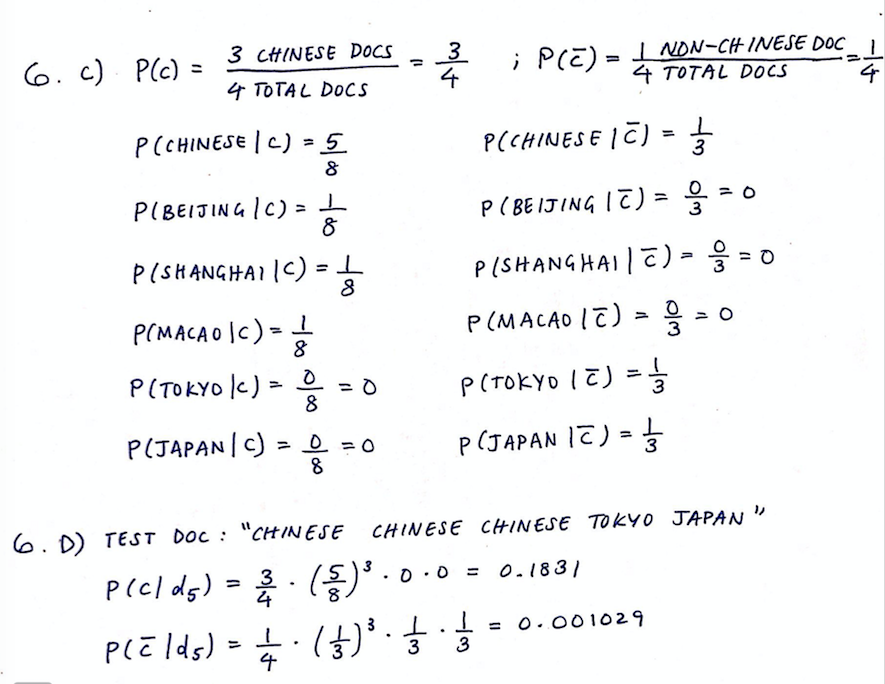

In [26]:
# part c/d - if you didn't write out your calcuations above, embed a picture of them here:
from IPython.display import Image
Image(filename="HW2_6C_6D.png")

# Question 7: Naive Bayes Inference.
In the next two questions you'll write code to parallelize the Naive Bayes calculations that you performed above. We'll do this in two phases: one MapReduce job to perform training and a second MapReduce to perform inference. While in practice we'd need to train a model before we can use it to classify documents, for learning purposes we're going to develop our code in the opposite order. By first focusing on the pieces of information/format we need to perform the classification (inference) task you should find it easier to develop a solid implementation for training phase when you get to question 8 below. In both of these questions we'll continue to use the Chinese example corpus from the textbook to help us test our MapReduce code as we develop it. Below we've reproduced the corpus, test set and model in text format that matches the Enron data.

### Q7 Tasks:
* __a) short response:__ run the provided cells to create the example files and load them in to HDFS. Then take a closer look at __`NBmodel.txt`__. This text file represents a Naive Bayes model trained (with Laplace +1 smoothing) on the example corpus. What are the 'keys' and 'values' in this file? Which record means something slightly different than the rest? The value field of each record includes two numbers which will be helpful for debugging but which we don't actually need to perform inference -- what are they? [`HINT`: _This file represents the model from Example 13.1 in the textbook, if you're having trouble getting oriented try comparing our file to the numbers in that example._]


* __b) short response:__ When performing Naive Bayes in practice instead of multiplying the probabilities (as in equation 13.3) we add their logs (as in equation 13.4). Why do we choose to work with log probabilities? If we had an unsmoothed model, what potential error could arise from this transformation?


* __c) short response:__ Documents 6 and 8 in the test set include a word that did not appear in the training corpus (and as a result does not appear in the model). What should we do at inference time when we need a class conditional probability for this word?


* __d) short response:__ The goal of our MapReduce job is to stream over the test set and classify each document by peforming the calculation from equation 13.4. To do this we'll load the model file (which contains the probabilities for equation 13.4) into memory on the nodes where we do our mapping. This is called an in-memory join. Does loading a model 'state' like this depart from the functional programming principles? Explain why or why not. From a scability perspective when would this kind of memory use be justified? when would it be unwise?


* __e) code:__ Complete the code in __`NaiveBayes/classify_mapper.py`__. Read the docstring carefully to understand how this script should work and the format it should return. Run the provided unit tests to confirm that your script works as expected then write a Hadoop streaming job to classify the Chinese example test set. [`HINT 1:` _you shouldn't need a reducer for this one._ `HINT 2:` _Don't forget to add the model file to the_ `-files` _parameter in your Hadoop streaming job so that it gets shipped to the mapper nodes where it will be accessed by your script._]


* __f) short response:__ In our test example and in the Enron data set we have fairly short documents. Since these fit fine in memory on a mapper node we didn't need a reducer and could just do all of our calculations in the mapper. However with much longer documents (eg. books) we might want a higher level of parallelization -- for example we might want to process parts of a document on different nodes. In this hypothetical scenario how would our algorithm design change? What could the mappers still do? What key-value structure would they emit? What would the reducers have to do as a last step?

### Q7 Student Answers:
> __a)__ The keys are each word found in the corpus. The values are the comma delimitted list of four floats which tell us (in order of appearance) the appearance in non-Chinese documents, the appearance in Chinese documents, the conditional probability of non-Chinese documents, and the conditional probability of Chinese documents. The ClassPriors key is different from the rest. The first two values (appearances in non-Chinese and Chinese documents) are helpful for debugging but not needed to perform the inference.

> __b)__ We work with log probabilities because the float multiplication could result in floating point underflow. With unsmoothed models, a potential error could be caused by taking the logarithm of zero because it would not be mathematically valid. For instance, the log of a word with 0 occurrences will be undefined, resulting in a runtime error.  

> __c)__ At inference time, we run into the problem of a dividing-by-zero error when calculating the conditional probability of the unseen words. One option is to skip the word: if the word does not exist in the vocabulary, it uses log(1), which results in a zero and essentially skips the word. A second option is to assign the unseen words a small non-zero probability (for which we would need the total word count and vocaubalary size of each class in order to perform the smoothing).

> __d)__ Loading a model into memory on the nodes where we do our mapping does depart from functional programming principles. Immutability would be violated each time we train our model. We also run the risk of running out of memory if the model is particularly large. The practice would be justified for scalability purposes if the model and input data is less than the size of the mapper node. If it is greater, the solution is not scalable.

> __e)__ Complete the coding portion of this question before answering 'f'.

> __f)__ Our algorithm design could change so that each node contributes a separate portion of the corpus (in alphabetical sequence). The mappers could be modified to allow partitioning based on the first letter of each word (i.e., creating 26 groups where each group contains only words starting with the specific letter of the alphabet). Their key-value structure would include a partition key for the letter of the alphabet and values entailing the words, class, and counts. As the last step, the reducers would combine the words of their designated partition and obtain the word count and frequency per class.

Run these cells to create the example corpus and model.

In [27]:
%%writefile NaiveBayes/chineseTrain.txt
D1	1		Chinese Beijing Chinese
D2	1		Chinese Chinese Shanghai
D3	1		Chinese Macao
D4	0		Tokyo Japan Chinese

Writing NaiveBayes/chineseTrain.txt


In [28]:
%%writefile NaiveBayes/chineseTest.txt
D5	1		Chinese Chinese Chinese Tokyo Japan
D6	1		Beijing Shanghai Trade
D7	0		Japan Macao Tokyo
D8	0		Tokyo Japan Trade

Writing NaiveBayes/chineseTest.txt


In [29]:
%%writefile NBmodel.txt
beijing	0.0,1.0,0.111111111111,0.142857142857
chinese	1.0,5.0,0.222222222222,0.428571428571
tokyo	1.0,0.0,0.222222222222,0.0714285714286
shanghai	0.0,1.0,0.111111111111,0.142857142857
ClassPriors	1.0,3.0,0.25,0.75
japan	1.0,0.0,0.222222222222,0.0714285714286
macao	0.0,1.0,0.111111111111,0.142857142857

Writing NBmodel.txt


In [30]:
# load the data files into HDFS
!hdfs dfs -copyFromLocal NaiveBayes/chineseTrain.txt {HDFS_DIR}
!hdfs dfs -copyFromLocal NaiveBayes/chineseTest.txt {HDFS_DIR}

copyFromLocal: `/user/root/HW2/chineseTrain.txt': File exists
copyFromLocal: `/user/root/HW2/chineseTest.txt': File exists


Your work for `part e` starts here:

In [31]:
# part e - do your work in NaiveBayes/classify_mapper.py first, then run this cell.
!chmod a+x NaiveBayes/classify_mapper.py

In [32]:
# part e - unit test NaiveBayes/classify_mapper.py (RUN THIS CELL AS IS)
!cat NaiveBayes/chineseTest.txt | NaiveBayes/classify_mapper.py | column -t

d5  1  -8.90668134500626   -8.10769031284611   1
d6  1  -5.780743515794329  -4.179502370564408  1
d7  0  -6.591673732011658  -7.511706880737811  0
d8  0  -4.394449154674438  -5.565796731681498  0


In [33]:
# part e - clear the output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/chinese-output

Deleted /user/root/HW2/chinese-output


In [34]:
# part e - write your Hadooop streaming job here
!hadoop jar {JAR_FILE} \
  -files NaiveBayes/classify_mapper.py,NBmodel.txt \
  -mapper classify_mapper.py \
  -reducer /bin/cat \
  -input {HDFS_DIR}/chineseTest.txt \
  -output {HDFS_DIR}/chinese-output \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob2665719174537426009.jar tmpDir=null
20/05/29 03:46:30 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/29 03:46:30 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/29 03:46:30 INFO mapred.FileInputFormat: Total input paths to process : 1
20/05/29 03:46:30 INFO mapreduce.JobSubmitter: number of splits:2
20/05/29 03:46:30 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1590718726048_0005
20/05/29 03:46:31 INFO impl.YarnClientImpl: Submitted application application_1590718726048_0005
20/05/29 03:46:31 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1590718726048_0005/
20/05/29 03:46:31 INFO mapreduce.Job: Running job: job_1590718726048_0005
20/05/29 03:46:37 INFO mapreduce.Job: Job job_1590718726048_0005 running in uber mode : false
20/05/29 03:46:37 INFO mapreduce.Job:  map 0% reduce 0%
20/05

In [35]:
# part e - retrieve test set results from HDFS (RUN THIS CELL AS IS)
!hdfs dfs -cat {HDFS_DIR}/chinese-output/part-000* > NaiveBayes/chineseResults.txt

In [36]:
# part e - take a look (RUN THIS CELL AS IS)
!cat NaiveBayes/chineseResults.txt | column -t

d5  1  -8.90668134500626   -8.10769031284611   1
d6  1  -5.780743515794329  -4.179502370564408  1
d7  0  -6.591673732011658  -7.511706880737811  0
d8  0  -4.394449154674438  -5.565796731681498  0


<table>
<th> Expected output for the test set:</th>
<tr align=Left><td><pre>
d5	1	-8.90668134	-8.10769031	1
d6	1	-5.78074351	-4.17950237	1
d7	0	-6.59167373	-7.51170688	0
d8	0	-4.39444915	-5.56579673	0
</pre></td><tr>
</table>

# Question 8: Naive Bayes Training.
In Question 7 we used a model that we had trained by hand. Next we'll develop the code to do that same training in parallel, making it suitable for use with larger corpora (like the Enron emails). The end result of the MapReduce job you write in this question should be a model text file that looks just like the example (`NBmodel.txt`) that we created by hand above.

To refresh your memory about the training process take a look at  `6a` and `6b` where you described the pieces of information you'll need to collect in order to encode a Multinomial Naive Bayes model. We now want to retrieve those pieces of information while streaming over a corpus. The bulk of the task will be very similar to the word counting excercises you've already done but you may want to consider a slightly different key-value record structure to efficiently tally counts for each class. 

The most challenging (interesting?) design question will be how to retrieve the totals (# of documents and # of words in documents for each class). Of course, counting these numbers is easy. The hard part is the timing: you'll need to make sure you have the counts totalled up _before_ you start estimating the class conditional probabilities for each word. It would be best (i.e. most scalable) if we could find a way to do this tallying without storing the whole vocabulary in memory... Use an appropriate MapReduce design pattern to implement this efficiently! 


### Q8 Tasks:
* __a) make a plan:__  Fill in the docstrings for __`NaiveBayes/train_mapper.py`__ and __`NaiveBayes/train_reducer.py`__ to appropriately reflect the format that each script will input/output. [`HINT:` _the input files_ (`enronemail_1h.txt` & `chineseTrain.txt`) _have a prespecified format and your output file should match_ `NBmodel.txt` _so you really only have to decide on an internal format for Hadoop_].


* __b) implement it:__ Complete the code in __`NaiveBayes/train_mapper.py`__ and __`NaiveBayes/train_reducer.py`__ so that together they train a Multinomial Naive Bayes model __with no smoothing__. Make sure your end result is formatted correctly (see note above). Test your scripts independently and together (using `chineseTrain.txt` or test input of your own devising). When you are satisfied with your Python code design and run a Hadoop streaming command to run your job in parallel on the __chineseTrain.txt__. Confirm that your trained model matches your hand calculations from Question 5.


* __c) short response:__ We saw in Question 6 that adding Laplace +1 smoothing makes our classifications less sensitve to rare words. However implementing this technique requires access to one additional piece of information that we had not previously used in our Naive Bayes training. What is that extra piece of information? [`HINT:` see equation 13.7 in Manning, Raghavan and Schutze].


* __d) short response:__ There are a couple of approaches that we could take to handle the extra piece of information you identified in `c`: 1) if we knew this extra information beforehand, we could provide it to our reducer as a configurable parameter for the vocab size dynamically (_where would we get it in the first place?_). Or 2) we could compute it in the reducer without storing any bulky information in memory but then we'd need some postprocessing or a second MapReduce job to complete the calculation (_why?_). Breifly explain what is non-ideal about each of these options. 


* __e) code + short response:__ Choose one of the 2 options above. State your choice & reasoning in the space below then use that strategy to complete the code in __`NaiveBayes/train_reducer_smooth.py`__. Test this alternate reducer then write and run a Hadoop streaming job to train an MNB model with smoothing on the Chinese example. Your results should match the model that we provided for you above (and the calculations in the textbook example). __IMPORTANT NOTE:__ For full credit on this question, your code must work with multiple reducers. 

    - [`HINT:` You will need to implement custom partitioning - [Total Order Sort Notebook](https://github.com/UCB-w261/main/tree/master/HelpfulResources/TotalSortGuide/_total-sort-guide-spark2.01-JAN27-2017.ipynb)] 

    - [`HINT:` Don't start from scratch with this one -- you can just copy over your reducer code from part `b` and make the needed modifications]. 



__IMPORTANT NOTE:__ For full credit on this question, your code must work with multiple reducers. [`HINT:`_You will need to implement custom partitioning - [Total Order Sort Notebook](https://github.com/UCB-w261/main/tree/master/HelpfulResources/TotalSortGuide/_total-sort-guide-spark2.01-JAN27-2017.ipynb)]


### Q8 Student Answers:
> __c)__ The missing piece of information is the number of unique words in our vocabulary. By contrast, our previous NB models relied on the total words in each class. 

> __d)__The first option is non-ideal is non-ideal because it does not accomodate new data being used in the model. Because our corpus is small, one possible workaround would be to count the number of unique words. Alternatively, a pre-processing step could be added to make a hash of all the words in the corpus and count the keys. The second option is also non-ideal because it introduces a post-processing task or second MapReduce job which would increase the computational cost of the algorithm.

> __e)__ I chose the first option because it requires getting the number of unique words in the corpus. The second option was also feasible since but it would entail another process, so the first option seemed to resemble the path of lesser resistance.

In [37]:
# part a - do your work in train_mapper.py and train_reducer.py then RUN THIS CELL AS IS
!chmod a+x NaiveBayes/train_mapper.py
!chmod a+x NaiveBayes/train_reducer.py
!echo "=========== MAPPER DOCSTRING ============"
!head -n 8 NaiveBayes/train_mapper.py | tail -n 6
!echo "=========== REDUCER DOCSTRING ============"
!head -n 8 NaiveBayes/train_reducer.py | tail -n 6

=========== MAPPER DOCSTRING ============
Mapper reads in text documents and emits word counts by class.
INPUT:                                                    
    DocID \t true_class \t subject \t body                
OUTPUT:                                                   
    partitionKey \t word \t class0_partialCount,class1_partialCount       
    
=========== REDUCER DOCSTRING ============
Reducer aggregates word counts by class and emits frequencies.

INPUT:
    partition \t word \t class \t count
OUTPUT:
    word \t non_chinese_count,chinese_count,non_chinese_cond_prob,chinese_cond_prob


__`part b starts here`:__ MNB _without_ Smoothing (training on Chinese Example Corpus).

In [38]:
# part b - write a unit test for your mapper here
!cat NaiveBayes/chineseTrain.txt | NaiveBayes/train_mapper.py

A	chinese	1	1
A	beijing	1	1
A	chinese	1	1
A	chinese	1	1
A	chinese	1	1
C	shanghai	1	1
A	chinese	1	1
B	macao	1	1
C	tokyo	0	1
B	japan	0	1
A	chinese	0	1
A	!totaldocs	0	1
A	!totaldocs	1	3
A	!totalwords	0	3
A	!totalwords	1	8
B	!totaldocs	0	1
B	!totaldocs	1	3
B	!totalwords	0	3
B	!totalwords	1	8
C	!totaldocs	0	1
C	!totaldocs	1	3
C	!totalwords	0	3
C	!totalwords	1	8


In [39]:
# part b - write a unit test for your reducer here
!echo -e "A	!totalwords	0	1\nB	!totaldocs	1	1\nA	!totalwords	1	1\nB	!totaldocs	0	1\nA	one	1	1\nA	one	0	1\nB	one	0	1\nC	two	0	1" | NaiveBayes/train_reducer.py

one	2.0,1.0,2.0,1.0
two	1.0,0,1.0,0.0
ClassPriors	1.0,1.0,0.5,0.5


In [40]:
# part b - write a systems test for your mapper + reducer together here
!cat NaiveBayes/chineseTrain.txt | NaiveBayes/train_mapper.py | sort -k1,1 | NaiveBayes/train_reducer.py

beijing	0,1.0,0.0,0.125
chinese	1.0,5.0,0.16666666666666666,0.3125
japan	1.0,0,0.16666666666666666,0.0
macao	0,1.0,0.0,0.041666666666666664
shanghai	0,1.0,0.0,0.041666666666666664
tokyo	1.0,0,0.1111111111111111,0.0
ClassPriors	3.0,9.0,0.25,0.75


In [41]:
# part b - clear (and name) an output directory in HDFS for your unsmoothed chinese NB model
!hdfs dfs -rm -r {HDFS_DIR}/unsmoothed-chinese-nb-model

Deleted /user/root/HW2/unsmoothed-chinese-nb-model


In [42]:
# part b - write your hadoop streaming job
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2" \
  -D mapreduce.partition.keypartitioner.options="-k1,1" \
  -files NaiveBayes/train_reducer.py,NaiveBayes/train_mapper.py \
  -mapper train_mapper.py \
  -reducer train_reducer.py \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/chineseTrain.txt \
  -output {HDFS_DIR}/unsmoothed-chinese-nb-model \
  -cmdenv PATH={PATH} \
  -numReduceTasks 3

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob5413679660827434421.jar tmpDir=null
20/05/29 03:48:53 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/29 03:48:53 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/29 03:48:54 INFO mapred.FileInputFormat: Total input paths to process : 1
20/05/29 03:48:54 INFO mapreduce.JobSubmitter: number of splits:2
20/05/29 03:48:54 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1590718726048_0006
20/05/29 03:48:54 INFO impl.YarnClientImpl: Submitted application application_1590718726048_0006
20/05/29 03:48:54 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1590718726048_0006/
20/05/29 03:48:54 INFO mapreduce.Job: Running job: job_1590718726048_0006
20/05/29 03:49:00 INFO mapreduce.Job: Job job_1590718726048_0006 running in uber mode : false
20/05/29 03:49:00 INFO mapreduce.Job:  map 0% reduce 0%
20/05

In [45]:
# part b - extract your results (i.e. model) to a local file
!mkdir NaiveBayes/Q8Unsmoothed
!rm NaiveBayes/Q8Unsmoothed/model.txt
!touch NaiveBayes/Q8Unsmoothed/model.txt
!hdfs dfs -cat {HDFS_DIR}/unsmoothed-chinese-nb-model/part-000* > NaiveBayes/Q8Unsmoothed/model.txt

rm: cannot remove `NaiveBayes/Q8Unsmoothed/model.txt': No such file or directory


In [46]:
# part b - print your model so that we can confirm that it matches expected results
!cat NaiveBayes/Q8Unsmoothed/model.txt

japan	1.0,0,0.3333333333333333,0.0
macao	0,1.0,0.0,0.125
ClassPriors	1.0,3.0,0.25,0.75
shanghai	0,1.0,0.0,0.125
tokyo	1.0,0,0.3333333333333333,0.0
ClassPriors	1.0,3.0,0.25,0.75
beijing	0,1.0,0.0,0.125
chinese	1.0,5.0,0.3333333333333333,0.625
ClassPriors	1.0,3.0,0.25,0.75


__`part e starts here`:__ MNB _with_ Smoothing (training on Chinese Example Corpus).

In [50]:
# part e - write a unit test for your NEW reducer here
!echo -e "A	!totalwords	0	1\nB	!totaldocs	1	1\nA	!totalwords	1	1\nB	!totaldocs	0	1\nA	one	1	1\nA	one	0	1\nB	one	0	1\nC	two	0	1" | NaiveBayes/train_reducer_smooth.py

/bin/sh: NaiveBayes/train_reducer_smooth.py: Permission denied


In [48]:
# part e - write a systems test for your mapper + reducer together here
!cat NaiveBayes/chineseTrain.txt | NaiveBayes/train_mapper.py | sort -k1,1 | NaiveBayes/train_reducer_smooth.py

/bin/sh: NaiveBayes/train_reducer_smooth.py: Permission denied
sort: fflush failed: standard output: Broken pipe
sort: write error


In [51]:
# part e - clear (and name) an output directory in HDFS for your SMOOTHED chinese NB model
!hdfs dfs -rm -r {HDFS_DIR}/smoothed-chinese-nb-model

rm: `/user/root/HW2//smoothed-chinese-nb-model': No such file or directory


In [52]:
# part e - write your hadoop streaming job
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2" \
  -D mapreduce.partition.keypartitioner.options="-k1,1" \
  -files NaiveBayes/train_reducer_smooth.py,NaiveBayes/train_mapper.py \
  -mapper train_mapper.py \
  -reducer train_reducer_smooth.py \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/chineseTrain.txt \
  -output {HDFS_DIR}/smoothed-chinese-nb-model \
  -cmdenv PATH={PATH} \
  -numReduceTasks 3

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob651062311566444166.jar tmpDir=null
20/05/29 03:56:18 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/29 03:56:18 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/29 03:56:18 INFO mapred.FileInputFormat: Total input paths to process : 1
20/05/29 03:56:18 INFO mapreduce.JobSubmitter: number of splits:2
20/05/29 03:56:18 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1590718726048_0007
20/05/29 03:56:19 INFO impl.YarnClientImpl: Submitted application application_1590718726048_0007
20/05/29 03:56:19 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1590718726048_0007/
20/05/29 03:56:19 INFO mapreduce.Job: Running job: job_1590718726048_0007
20/05/29 03:56:25 INFO mapreduce.Job: Job job_1590718726048_0007 running in uber mode : false
20/05/29 03:56:25 INFO mapreduce.Job:  map 0% reduce 0%
20/05/

In [55]:
# part e - extract your results (i.e. model) to a local file
!mkdir NaiveBayes/Q8Smoothed
!rm NaiveBayes/Q8Smoothed/model.txt
!touch NaiveBayes/Q8Smoothed/model.txt
!hdfs dfs -cat {HDFS_DIR}/smoothed-chinese-nb-model/part-000* > NaiveBayes/Q8Smoothed/model.txt
!cat NaiveBayes/Q8Smoothed/model.txt

mkdir: cannot create directory `NaiveBayes/Q8Smoothed': File exists
japan	1,0,0.0004385964912280702,0.0002190580503833516
macao	0,1,0.0002192982456140351,0.0004381161007667032
ClassPriors	1.0,3.0,0.25,0.75
shanghai	0,1,0.0002192982456140351,0.0004381161007667032
tokyo	1,0,0.0004385964912280702,0.0002190580503833516
ClassPriors	1.0,3.0,0.25,0.75
beijing	0,1,0.0002192982456140351,0.0004381161007667032
chinese	1.0,5.0,0.0004385964912280702,0.0013143483023001095
ClassPriors	1.0,3.0,0.25,0.75


# Question 9: Enron Ham/Spam NB Classifier & Results.

Fantastic work. We're finally ready to perform Spam Classification on the Enron Corpus. In this question you'll run the analysis you've developed, report its performance.

### Q9 Tasks:
* __a) train/test split:__ Run the provided code to split our Enron file into a training set and testing set then load them into HDFS. [`NOTE:` _Make sure you re calculate the vocab size for just the training set!_]

* __b) train 2 models:__ Write Hadoop Streaming jobs to train MNB Models on the training set with and without smoothing. Save your models to local files at __`NaiveBayes/Unsmoothed/NBmodel.txt`__ and __`NaiveBayes/Smoothed/NBmodel.txt`__. [`NOTE:` _This naming is important because we wrote our classification task so that it expects a file of that name... if this inelegance frustrates you there is an alternative that would involve a few adjustments to your code [read more about it here](http://www.tnoda.com/blog/2013-11-23)._] Finally run the checks that we provide to confirm that your results are correct.


* __c) code:__ Recall that we designed our classification job with just a mapper. An efficient way to report the performance of our models would be to simply add a reducer phase to this job and compute precision and recall right there. Complete the code in __`NaiveBayes/evaluation_reducer.py`__ and then write Hadoop jobs to evaluate your two models on the test set. Report their performance side by side. [`NOTE:` if you need a refresher on precision, recall and F1-score [Wikipedia](https://en.wikipedia.org/wiki/F1_score) is a good resource.]


* __d) short response:__ Compare the performance of your two models. What do you notice about the unsmoothed model's predictions? Can you guess why this is happening? Which evaluation measure do you think is most relevant in our use case? [`NOTE:` _Feel free to answer using your common sense but if you want more information on evaluating the classification task checkout_ [this blogpost](https://tryolabs.com/blog/2013/03/25/why-accuracy-alone-bad-measure-classification-tasks-and-what-we-can-do-about-it/
) or [this paper](http://www.flinders.edu.au/science_engineering/fms/School-CSEM/publications/tech_reps-research_artfcts/TRRA_2007.pdf
)]



### Q9 Student Answers:
> __d)__ The performance of the smoothed model is much better than that of the unsmoothed model as given by the F-Score results (0.1666 vs. 0.88). The unsmoothed model predicts negative (not spam) across 19 of the 20 documents indicating it is biased towards negative predictions. It is possible that the corpus did not contain a sufficient number of spam words and as a result, the model was not adequantely trained on words that would be indicative of spam. The Recall measure is likely the most relevant for our use case because it reflects the lack of true positive predictions and the high false negative ratio. 

__Test/Train split__

In [56]:
# part a - test/train split (RUN THIS CELL AS IS)
# changed paths to reflect nested master folder
!head -n 80 {ENRON} > master/data/enron_train.txt
!tail -n 20 {ENRON} > master/data/enron_test.txt
!hdfs dfs -copyFromLocal master/data/enron_train.txt {HDFS_DIR}
!hdfs dfs -copyFromLocal master/data/enron_test.txt {HDFS_DIR}

copyFromLocal: `/user/root/HW2/enron_train.txt': File exists
copyFromLocal: `/user/root/HW2/enron_test.txt': File exists


In [84]:
# part a - calculate vocab size of training set
!cat master/data/enron_train.txt | NaiveBayes/word_count.py

/bin/sh: NaiveBayes/word_count.py: Permission denied
cat: write error: Broken pipe


__Training__ (Enron MNB Model _without smoothing_ )

In [58]:
# part b -  Unsmoothed model (FILL IN THE MISSING CODE BELOW)

# clear the output directory
!hdfs dfs -rm -r {HDFS_DIR}/enron-model

# hadoop command
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2" \
  -D mapreduce.partition.keypartitioner.options="-k1,1" \
  -files NaiveBayes/train_reducer.py,NaiveBayes/train_mapper.py \
  -mapper train_mapper.py \
  -reducer train_reducer.py \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/enron_train.txt \
  -output {HDFS_DIR}/enron-model \
  -cmdenv PATH={PATH} \
  -numReduceTasks 3

# save the model locally
!mkdir NaiveBayes/Unsmoothed
!rm NaiveBayes/Unsmoothed/NBmodel.txt
!hdfs dfs -cat {HDFS_DIR}/enron-model/part-000* > NaiveBayes/Unsmoothed/NBmodel.txt

Deleted /user/root/HW2/enron-model
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob3006431582679888353.jar tmpDir=null
20/05/29 04:02:03 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/29 04:02:03 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/29 04:02:04 INFO mapred.FileInputFormat: Total input paths to process : 1
20/05/29 04:02:04 INFO mapreduce.JobSubmitter: number of splits:2
20/05/29 04:02:04 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1590718726048_0008
20/05/29 04:02:04 INFO impl.YarnClientImpl: Submitted application application_1590718726048_0008
20/05/29 04:02:04 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1590718726048_0008/
20/05/29 04:02:04 INFO mapreduce.Job: Running job: job_1590718726048_0008
20/05/29 04:02:10 INFO mapreduce.Job: Job job_1590718726048_0008 running in uber mode : false
20/05/29 04:02:10 INFO map

In [61]:
# part b - check your UNSMOOTHED model results (RUN THIS CELL AS IS)
!grep assistance NaiveBayes/Unsmoothed/NBmodel.txt
# EXPECTED OUTPUT: assistance	2,4,0.000172547666293,0.000296823983378

assistance	2.0,4.0,0.0001725625539257981,0.0002968460111317254


In [62]:
# part b - check your UNSMOOTHED model results (RUN THIS CELL AS IS)
!grep money NaiveBayes/Unsmoothed/NBmodel.txt
# EXPECTED OUTPUT: money	1,22,8.62738331464e-05,0.00163253190858

money	1.0,22.0,8.628127696289905e-05,0.0016326530612244899


__Training__ (Enron MNB Model _with Laplace +1 smoothing_ )

In [63]:
# part b -  Smoothed model (FILL IN THE MISSING CODE BELOW)

# clear the output directory
!hdfs dfs -rm -r {HDFS_DIR}/smooth-model

# hadoop command
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2" \
  -D mapreduce.partition.keypartitioner.options="-k1,1" \
  -files NaiveBayes/train_reducer_smooth.py,NaiveBayes/train_mapper.py \
  -mapper train_mapper.py \
  -reducer train_reducer_smooth.py \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/enron_train.txt \
  -output {HDFS_DIR}/smooth-model \
  -cmdenv PATH={PATH} \
  -numReduceTasks 3

# save the model locally
!mkdir NaiveBayes/Smoothed
!rm NaiveBayes/Smoothed/NBmodel.txt
!hdfs dfs -cat {HDFS_DIR}/smooth-model/part-000* > NaiveBayes/Smoothed/NBmodel.txt

Deleted /user/root/HW2/smooth-model
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob2267391721883591864.jar tmpDir=null
20/05/29 04:03:43 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/29 04:03:43 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/29 04:03:43 INFO mapred.FileInputFormat: Total input paths to process : 1
20/05/29 04:03:43 INFO mapreduce.JobSubmitter: number of splits:2
20/05/29 04:03:43 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1590718726048_0009
20/05/29 04:03:44 INFO impl.YarnClientImpl: Submitted application application_1590718726048_0009
20/05/29 04:03:44 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1590718726048_0009/
20/05/29 04:03:44 INFO mapreduce.Job: Running job: job_1590718726048_0009
20/05/29 04:03:50 INFO mapreduce.Job: Job job_1590718726048_0009 running in uber mode : false
20/05/29 04:03:50 INFO ma

In [64]:
# part b - check your SMOOTHED model results (RUN THIS CELL AS IS)
!grep assistance NaiveBayes/Smoothed/NBmodel.txt
# EXPECTED OUTPUT: assistance	2,4,0.000185804533631,0.000277300205202

assistance	2.0,4.0,0.0001857930265684028,0.00027728482697426796


In [65]:
# part b - check your SMOOTHED model results (RUN THIS CELL AS IS)
!grep money NaiveBayes/Smoothed/NBmodel.txt
# EXPECTED OUTPUT: money	1,22,0.000123869689087,0.00127558094393

money	1,22.0,0.00012386201771226853,0.0012755102040816326


__Evaluation__

In [66]:
# part c - write your code in NaiveBayes/evaluation_reducer.py then RUN THIS
!chmod a+x NaiveBayes/evaluation_reducer.py

In [76]:
# part c - unit test your evaluation job on the chinese model (RUN THIS CELL AS IS)
!cat NaiveBayes/chineseTest.txt | NaiveBayes/classify_mapper.py 
!cat NaiveBayes/chineseTest.txt | NaiveBayes/classify_mapper.py | NaiveBayes/evaluation_reducer.py

d5	1	-8.90668134500626	-8.10769031284611	1
d6	1	-5.780743515794329	-4.179502370564408	1
d7	0	-6.591673732011658	-7.511706880737811	0
d8	0	-4.394449154674438	-5.565796731681498	0
d5	1	-8.90668134500626	-8.10769031284611	 True
d6	1	-5.780743515794329	-4.179502370564408	 True
d7	0	-6.591673732011658	-7.511706880737811	 True
d8	0	-4.394449154674438	-5.565796731681498	 True
# Documents 	 4.0
True Positives 	 2.0
True Negatives 	 2.0
False Positives 	 0.0
False Negatives 	 0.0
Accuracy 	 1.0
Precision 	 1.0
Recall 	 1.0
F-Score 	 1.0


In [77]:
# part c - Evaluate the UNSMOOTHED Model Here (FILL IN THE MISSING CODE)

# clear output directory
!hdfs dfs -rm -r {HDFS_DIR}/evaluate-unsmooth-model

# hadoop job
!hadoop jar {JAR_FILE} \
  -files NaiveBayes/classify_mapper.py,NaiveBayes/evaluation_reducer.py,NaiveBayes/Unsmoothed/NBmodel.txt \
  -mapper classify_mapper.py \
  -reducer evaluation_reducer.py \
  -input {HDFS_DIR}/enron_test.txt \
  -output {HDFS_DIR}/evaluate-unsmooth-model \
  -cmdenv PATH={PATH} \

# retrieve results locally
!rm NaiveBayes/Unsmoothed/results.txt
!hdfs dfs -cat {HDFS_DIR}/evaluate-unsmooth-model/part-000* > NaiveBayes/Unsmoothed/results.txt

Deleted /user/root/HW2/evaluate-unsmooth-model
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob7482370649028700373.jar tmpDir=null
20/05/29 05:46:58 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/29 05:46:59 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/29 05:46:59 INFO mapred.FileInputFormat: Total input paths to process : 1
20/05/29 05:46:59 INFO mapreduce.JobSubmitter: number of splits:2
20/05/29 05:46:59 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1590718726048_0012
20/05/29 05:46:59 INFO impl.YarnClientImpl: Submitted application application_1590718726048_0012
20/05/29 05:46:59 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1590718726048_0012/
20/05/29 05:46:59 INFO mapreduce.Job: Running job: job_1590718726048_0012
20/05/29 05:47:06 INFO mapreduce.Job: Job job_1590718726048_0012 running in uber mode : false
20/05/29 05:47

In [78]:
# part c - Evaluate the SMOOTHED Model Here (FILL IN THE MISSING CODE)

# clear output directory
!hdfs dfs -rm -r {HDFS_DIR}/evaluate-smooth-model

# hadoop job
!hadoop jar {JAR_FILE} \
  -files NaiveBayes/classify_mapper.py,NaiveBayes/evaluation_reducer.py,NaiveBayes/Smoothed/NBmodel.txt \
  -mapper classify_mapper.py \
  -reducer evaluation_reducer.py \
  -input {HDFS_DIR}/enron_test.txt \
  -output {HDFS_DIR}/evaluate-smooth-model \
  -cmdenv PATH={PATH}

# retrieve results locally
!rm NaiveBayes/Smoothed/results.txt
!hdfs dfs -cat {HDFS_DIR}/evaluate-smooth-model/part-000* > NaiveBayes/Smoothed/results.txt

Deleted /user/root/HW2/evaluate-smooth-model
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob6860197969645196036.jar tmpDir=null
20/05/29 05:47:26 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/29 05:47:27 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/29 05:47:27 INFO mapred.FileInputFormat: Total input paths to process : 1
20/05/29 05:47:27 INFO mapreduce.JobSubmitter: number of splits:2
20/05/29 05:47:27 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1590718726048_0013
20/05/29 05:47:27 INFO impl.YarnClientImpl: Submitted application application_1590718726048_0013
20/05/29 05:47:27 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1590718726048_0013/
20/05/29 05:47:27 INFO mapreduce.Job: Running job: job_1590718726048_0013
20/05/29 05:47:34 INFO mapreduce.Job: Job job_1590718726048_0013 running in uber mode : false
20/05/29 05:47:3

In [79]:
# part c - display results 
# NOTE: feel free to modify the tail commands to match the format of your results file
print('=========== UNSMOOTHED MODEL ============')
!tail -n 9 NaiveBayes/Unsmoothed/results.txt
print('=========== SMOOTHED MODEL ============')
!tail -n 9 NaiveBayes/Smoothed/results.txt

=========== UNSMOOTHED MODEL ============
# Documents 	 20.0
True Positives 	 1.0
True Negatives 	 9.0
False Positives 	 0.0
False Negatives 	 10.0
Accuracy 	 0.5
Precision 	 1.0
Recall 	 0.09090909090909091
F-Score 	 0.16666666666666669
=========== SMOOTHED MODEL ============
# Documents 	 20.0
True Positives 	 11.0
True Negatives 	 6.0
False Positives 	 3.0
False Negatives 	 0.0
Accuracy 	 0.85
Precision 	 0.7857142857142857
Recall 	 1.0
F-Score 	 0.88


__`EXPECTED RESULTS:`__ 
<table>
<th>Unsmoothed Model</th>
<th>Smoothed Model</th>
<tr>
<td><pre>
# Documents:	20
True Positives:	1
True Negatives:	9
False Positives:	0
False Negatives:	10
Accuracy	0.5
Precision	1.0
Recall	0.0909
F-Score	0.1666
</pre></td>
<td><pre>
# Documents:	20
True Positives:	11
True Negatives:	6
False Positives:	3
False Negatives:	0
Accuracy	0.85
Precision	0.7857
Recall	1.0
F-Score	0.88
</pre></td>
</tr>
</table>

__`NOTE:`__ _Don't be too disappointed if these seem low to you. We've trained and tested on a very very small corpus... bigger datasets coming soon!_

# Question 10: Custom Partitioning and Secondary Sort

Now that we have our model, we can analyse the results and think about future improvements.

### Q10 Tasks:

* __a) code + short response:__ Let's look at the top ten words with the highest conditional probability in `Spam` and in `Ham`. We'll do this by writing a Hadoop job that sorts the model file (`NaiveBayes/Smoothed/NBmodel.py`). Normally we'd have to run two jobs -- one that sorts on $P(word|ham)$ and another that sorts on $P(word|spam)$. However if we slighly modify the data format in the model file then we can get the top words in each class with just one job. We've written a mapper that will do just this for you. Read through __`NaiveBayes/model_sort_mapper.py`__ and then briefly explain how this mapper will allow us to partition and sort our model file. Write a Hadoop job that uses our mapper and `/bin/cat` for a reducer to partition and sort. Print out the top 10 words in each class (where 'top' == highest conditional probability).[`HINT:` _this should remind you a lot of what we did in Question 6._]


* __b) short response:__ What do you notice about the 'top words' we printed in `a`? How would increasing the smoothing parameter 'k' affect the probabilities for the top words that you identified for 'a'. How would they affect the probabilities of words that occur much more in one class than another? In summary, how does the smoothing parameter 'k' affect the bias and the variance of our model. [`NOTE:` _you do not need to code anything for this task, but if you are struggling with it you could try changing 'k' and see what happens to the test set. We don't recommend doing this exploration with the Enron data because it will be harder to see the impact with such a big vocabulary_]

### Q10 Student Answers:
> __a)__ The model_sort_mapper.py file creates two new output fields (maxClass and maxClassProbability) for the NB parameters, which help sort an email as spam or ham. We can use maxClassProbability as the primary sorting key from which we can output the first few lines to view the top words from each class. 

> __b)__ The top words found in part a seem to be commonly used pronouns, prepositions, or conjuctions (e.g., to, for, you, and, but, of, in, on, etc.). For the higher probability class, increasing the smoothing paramter 'k' would result in a lower (more smoothed) probability. For the lower probability class, increasing 'k' would increase the probability for the top words. It would also slightly increase the probability of words which occur more in once class than another. In summary, the smoothing parameter 'k' reduces the bias of our model because it makes the model less sensitive to higher probability features and allows the use of higher variance data.

In [80]:
# part a - write your Hadoop job here (sort smoothed model on P(word|class))

# clear output directory
!hdfs dfs -rm -r {HDFS_DIR}/sort-smooth-model

# upload smoothed MNB model
!hdfs dfs -copyFromLocal NaiveBayes/Smoothed/NBmodel.txt {HDFS_DIR}

# hadoop job
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=4 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k4,4nr" \
  -D mapreduce.partition.keypartitioner.options="-k1,1" \
  -files NaiveBayes/model_sort_mapper.py,NaiveBayes/Smoothed/NBmodel.txt \
  -mapper model_sort_mapper.py \
  -reducer /bin/cat \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/NBmodel.txt \
  -output {HDFS_DIR}/sort-smooth-model \
  -cmdenv PATH={PATH}

rm: `/user/root/HW2//sort-smooth-model': No such file or directory
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob2386945066607953228.jar tmpDir=null
20/05/29 05:48:42 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/29 05:48:42 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/29 05:48:43 INFO mapred.FileInputFormat: Total input paths to process : 1
20/05/29 05:48:43 INFO mapreduce.JobSubmitter: number of splits:2
20/05/29 05:48:43 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1590718726048_0014
20/05/29 05:48:43 INFO impl.YarnClientImpl: Submitted application application_1590718726048_0014
20/05/29 05:48:43 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1590718726048_0014/
20/05/29 05:48:43 INFO mapreduce.Job: Running job: job_1590718726048_0014
20/05/29 05:48:49 INFO mapreduce.Job: Job job_1590718726048_0014 running in uber mode : 

In [82]:
# part b - print top words in each class
!rm NaiveBayes/Smoothed/sort_results.txt
!hdfs dfs -cat {HDFS_DIR}/sort-smooth-model/part-000* > NaiveBayes/Smoothed/sort_results.txt
!cat NaiveBayes/Smoothed/sort_results.txt | head -n 20

the	453.0,535.0,0.028116678020684956,0.029724933451641525	spam	0.029724933451641525	
ect	378.0,0,0.023471852356474886,5.5456965394853596e-05	ham	0.023471852356474886	
to	350.0,420.0,0.021737784108503126,0.02334738243123336	spam	0.02334738243123336	
and	258.0,277.0,0.016040131293738775,0.0154170363797693	ham	0.016040131293738775	
a	168.0,274.0,0.010466340496686691,0.015250665483584738	spam	0.015250665483584738	
your	35.0,271.0,0.0022295163188208334,0.015084294587400177	spam	0.015084294587400177	
you	80.0,252.0,0.005016411717346876,0.01403061224489796	spam	0.01403061224489796	
of	188.0,252.0,0.011704960673809377,0.01403061224489796	spam	0.01403061224489796	
hou	203.0,0,0.01263392580665139,5.5456965394853596e-05	ham	0.01263392580665139	
in	160.0,157.0,0.009970892425837617,0.008762200532386868	ham	0.009970892425837617	
for	148.0,153.0,0.009227720319564005,0.008540372670807454	ham	0.009227720319564005	
on	122.0,95.0,0.007617514089304515,0.005323868677905945	ham	0.007617514089304515	
enron	1

### Congratulations, you have completed HW2! Please refer to the readme for submission instructions.

If you would like to provide feedback regarding this homework, please use the survey at: https://docs.google.com/forms/d/e/1FAIpQLSce9feiQeSkdP43A0ZYui1tMGIBfLfzb0rmgToQeZD9bXXX8Q/viewform